# Tiny Imagenet (Part I)

> Scaling up the dataset and training a UNet model

Adapted from

- [https://www.youtube.com/watch?v=z1In7QaG0fg](https://www.youtube.com/watch?v=z1In7QaG0fg)

In [1]:
#| default_exp tinyimagenet_a

In [5]:
# |export
import subprocess
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from datasets import Dataset, DatasetDict
from datasets import Image as DatasetsImage
from datasets import load_dataset
from PIL import Image
from torch import nn
from torch.optim import AdamW, lr_scheduler
from torchmetrics.classification import MulticlassAccuracy

from slowai.augmentation import ResidualConvBlock, ResNetWithGlobalPooling, summarize
from slowai.initializations import init_leaky_weights
from slowai.learner import (
    Callback,
    DataLoaders,
    DeviceCB,
    MetricsCB,
    ProgressCB,
    TrainLearner,
)
from slowai.resnets import Conv, GeneralReLU, ResidualConvBlock
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_images

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# |export
def tiny_imagenet(dir_=Path("../tiny-imagenet-200")):
    download_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    if not dir_.exists():
        cmd = f"""
        cd .. && wget {download_url} && unzip tiny-imagenet-200.zip || rm "../tiny-imagenet-200.zip*"
        """
        subprocess.call(cmd, shell=True)
    return dir_

In [7]:
# Download, if needed
tiny_imagenet();

In [8]:
# |export
class TinyImageNetDatasetGenerator:
    """Generate Tiny Imagenet rows lazily from zip file"""

    def __init__(self, base_dir=None):
        if base_dir is None:
            base_dir = Path(tiny_imagenet())
        self.base_dir = base_dir
        self.wn2word = {}
        with (base_dir / "words.txt").open() as f:
            for line in f:
                wn, word = line.strip().split("\t")
                self.wn2word[wn] = word
        self.wn2id = {}
        with (base_dir / "wnids.txt").open() as f:
            for idx, wn in enumerate(f):
                self.wn2id[wn.strip()] = idx

    def gen_train(self):
        for fp in (self.base_dir / "train").glob("*/images/*"):
            wn = fp.parent.parent.name.strip()
            word = self.wn2word[wn]
            idx = self.wn2id[wn]
            yield {"image": str(fp), "idx": idx, "word": word}

    def gen_test(self):
        annotations_fp = self.base_dir / "val" / "val_annotations.txt"
        with open(annotations_fp) as f:
            for line in f:
                fname, wn, *_ = line.split("\t")
                fp = self.base_dir / "val" / "images" / fname
                assert fp.exists()
                word = self.wn2word[wn]
                idx = self.wn2id[wn]
                yield {"image": str(fp), "idx": idx, "word": word}

In [9]:
upload = False
if upload:
    dg = TinyImageNetDatasetGenerator()
    splits = {}
    for split, split_gen in [("train", dg.gen_train), ("test", dg.gen_test)]:
        # Ensure at least one record
        next(iter(split_gen()))
        ds = Dataset.from_generator(split_gen)
        ds = ds.cast_column("image", DatasetsImage())
        splits[split] = ds
    dsd = DatasetDict(splits)
    dsd.push_to_hub("jeremyf/tiny-imagent-200")

In [10]:
# |export
def tiny_imagenet_dataset_dict():
    """Huggingface dataset from the HF hub"""
    return load_dataset("jeremyf/tiny-imagent-200")

In [11]:
# |export
def to_rgb(img):
    return img.convert("RGB")

In [12]:
# |export
μ = torch.tensor([0.48, 0.40, 0.31])
Σ = torch.tensor([0.28, 0.24, 0.27])

In [13]:
# |export
def norm(x):
    x = x - μ[:, None, None]
    x = x / Σ[:, None, None]
    return x

In [14]:
# |export
def denorm(x):
    x = x * Σ[:, None, None]
    x = x + μ[:, None, None]
    return x

In [15]:
# |export
preprocess = [
    to_rgb,
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    norm,
]

In [16]:
# |export
def preprocess_factory(pipe_):
    pipe = torchvision.transforms.Compose(pipe_)

    def preprocess(examples):
        images = []
        for image in examples["image"]:
            image = pipe(image)
            images.append(image)
        x = torch.stack(images)
        examples["image"] = x
        return examples

    return preprocess

In [17]:
# |export
def get_imagenet_dls(bs=512, with_word=False, training_preprocessor=preprocess):
    dsd = tiny_imagenet_dataset_dict()
    dsd["train"].set_transform(preprocess_factory(training_preprocessor))
    dsd["train"] = dsd["train"].shuffle()
    dsd["test"] = (
        dsd["test"]
        .map(preprocess_factory(preprocess), batched=True)
        .with_format("torch")
    )
    columns = ["image", "idx"]
    if with_word:
        columns.append("word")
    return DataLoaders.from_dsd(dsd, bs=bs).listify(columns=columns)

In [18]:
%%time
dls = get_imagenet_dls(with_word=True)

Extracting data files: 100%|█████████████████████| 2/2 [00:00<00:00, 614.82it/s]
Generating train split: 100%|█| 100000/100000 [00:00<00:00, 233408.11 examples/s
Map: 100%|████████████████████████| 10000/10000 [00:10<00:00, 913.89 examples/s]

CPU times: user 12.4 s, sys: 2.92 s, total: 15.3 s
Wall time: 1min 20s


In [21]:
# |export
def viz(dls):
    try:
        xb, _, words = dls.peek()
    except ValueError:
        xb, _ = dls.peek()
        show_images(denorm(xb)[:6].squeeze())
    else:
        titles = [w[:25].strip() for w in words]
        show_images(denorm(xb)[:6].squeeze(), titles=titles[:6])

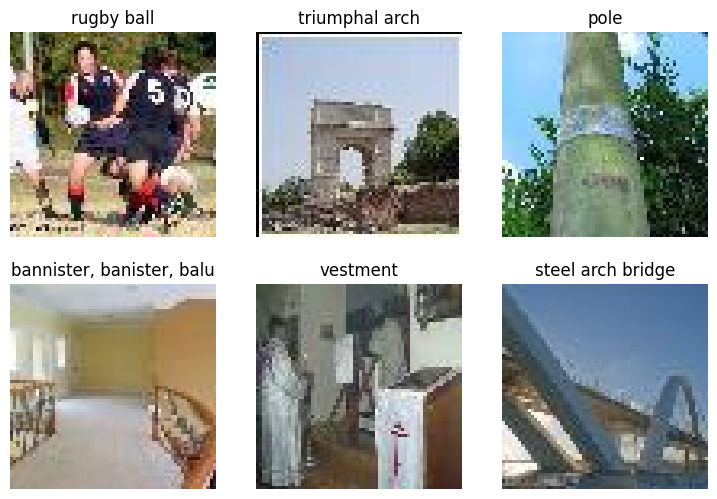

In [22]:
viz(dls)

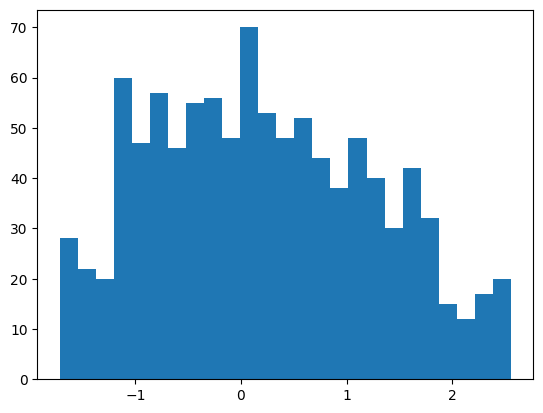

In [16]:
xb, _, words = dls.peek()
pixels = xb.reshape(-1)
pixels = pixels[torch.randperm(len(pixels))]
plt.hist(pixels[:1000], bins=25);

In [17]:
xb.min(), xb.max()

(tensor(-1.7143), tensor(2.5556))

Let's implement the model with color and a slightly fancier final pooling layer.

In [18]:
nn.AdaptiveAvgPool2d?

Init signature:
nn.AdaptiveAvgPool2d(
    output_size: Union[int, NoneType, Tuple[Optional[int], ...]],
) -> None
Docstring:     
Applies a 2D adaptive average pooling over an input signal composed of several input planes.

The output is of size H x W, for any input size.
The number of output features is equal to the number of input planes.

Args:
    output_size: the target output size of the image of the form H x W.
                 Can be a tuple (H, W) or a single H for a square image H x H.
                 H and W can be either a ``int``, or ``None`` which means the size will
                 be the same as that of the input.

Shape:
    - Input: :math:`(N, C, H_{in}, W_{in})` or :math:`(C, H_{in}, W_{in})`.
    - Output: :math:`(N, C, S_{0}, S_{1})` or :math:`(C, S_{0}, S_{1})`, where
      :math:`S=\text{output\_size}`.

Examples:
    >>> # target output size of 5x7
    >>> m = nn.AdaptiveAvgPool2d((5, 7))
    >>> input = torch.randn(1, 64, 8, 9)
    >>> output = m(input)
    >

In [19]:
class TinyImageResNet1(nn.Module):
    def __init__(
        self,
        nfs,
        n_outputs=10,
        p_drop=0.1,
    ):
        super().__init__()
        self.nfs = nfs
        self.n_outputs = n_outputs
        self.layers = nn.Sequential(*self.get_layers(nfs, n_outputs))
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
        )
        self.drop = nn.Dropout(p_drop)
        self.lin = nn.Linear(nfs[-1], n_outputs, bias=False)
        self.norm = nn.BatchNorm1d(n_outputs)

    def get_layers(self, nfs, n_outputs=10):
        layers = [Conv(3, nfs[0], ks=5, stride=1)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            block = ResidualConvBlock(c_in, c_out)
            layers.append(block)
        return layers

    def forward(self, x):
        x = self.layers(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.lin(x)
        x = self.norm(x)
        return x

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights)
        return model

In [20]:
dls = get_imagenet_dls(bs=512)  # We don't want the human-readable labels

In [21]:
model = TinyImageResNet1.kaiming(
    n_outputs=200,
    nfs=[32, 64, 128, 256, 512, 1024],
)
summarize(model, [*model.layers, model.lin, model.norm], get_imagenet_dls())

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (512, 3, 64, 64) | (512, 32, 64, 64) | 2,464 | 9.8
| ResidualConvBlock | (512, 32, 64, 64) | (512, 64, 32, 32) | 57,664 | 58.7
| ResidualConvBlock | (512, 64, 32, 32) | (512, 128, 16, 16) | 230,016 | 58.7
| ResidualConvBlock | (512, 128, 16, 16) | (512, 256, 8, 8) | 918,784 | 58.7
| ResidualConvBlock | (512, 256, 8, 8) | (512, 512, 4, 4) | 3,672,576 | 58.7
| ResidualConvBlock | (512, 512, 4, 4) | (512, 1024, 2, 2) | 14,685,184 | 58.7
| Linear | (512, 1024) | (512, 200) | 204,800 | 0.2
| BatchNorm1d | (512, 200) | (512, 200) | 400 | 0.0
| Total | | | 19,771,888 | 303.646864 |

In [22]:
# |export
def lr_find(
    model,
    dls,
    start_lr,
    gamma=1.3,
    n_epochs=2,
    extra_cbs=(),
    loss_fn=F.cross_entropy,
):
    TrainLearner(
        model,
        dls,
        loss_fn,
        lr=start_lr,
        cbs=[DeviceCB(), ProgressCB(plot=True), *extra_cbs],
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    ).lr_find(
        start_lr=start_lr,
        gamma=gamma,
        max_epochs=n_epochs,
    )

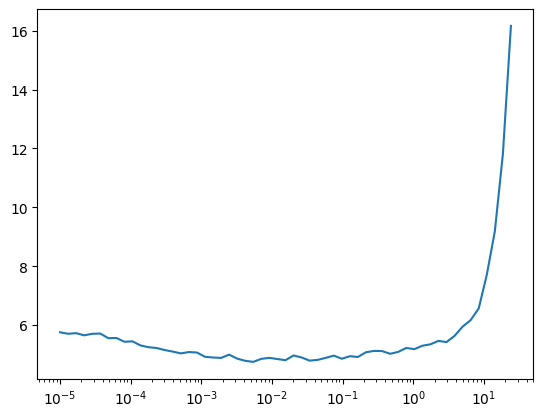

In [23]:
lr_find(model, dls, start_lr=1e-5)

In [24]:
# |export
def train(
    model,
    dls,
    lr=1e-2,
    n_epochs=2,
    extra_cbs=tuple(),
):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        MetricsCB(MulticlassAccuracy(num_classes=200)),
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        *extra_cbs,
    ]
    learner = TrainLearner(
        model,
        dls,
        F.cross_entropy,
        lr=lr,
        cbs=cbs,
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    )
    learner.fit(n_epochs)

MulticlassAccuracy,loss,epoch,train
0.081,4.524,0,train
0.119,4.143,0,eval
0.180,3.747,1,train
0.182,3.735,1,eval
0.242,3.359,2,train
0.193,3.809,2,eval
0.284,3.119,3,train
0.189,3.818,3,eval
0.312,2.964,4,train
0.178,4.275,4,eval


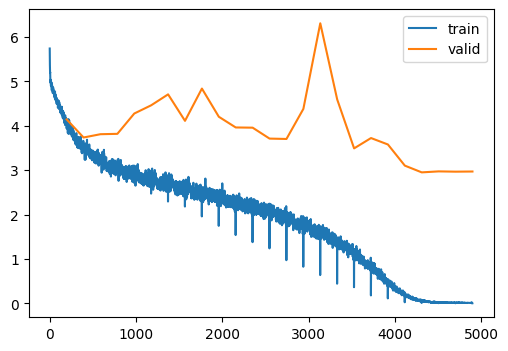

In [25]:
model = TinyImageResNet1.kaiming(
    n_outputs=200,
    nfs=[32, 64, 128, 256, 512, 1024],
)
train(model, dls, lr=0.1, n_epochs=25)

That's clearly overfitting. Let's add some minor augmentation.

In [26]:
T.RandomErasing?

Init signature:
T.RandomErasing(
    p=0.5,
    scale=(0.02, 0.33),
    ratio=(0.3, 3.3),
    value=0,
    inplace=False,
)
Docstring:     
Randomly selects a rectangle region in a torch.Tensor image and erases its pixels.
This transform does not support PIL Image.
'Random Erasing Data Augmentation' by Zhong et al. See https://arxiv.org/abs/1708.04896

Args:
     p: probability that the random erasing operation will be performed.
     scale: range of proportion of erased area against input image.
     ratio: range of aspect ratio of erased area.
     value: erasing value. Default is 0. If a single int, it is used to
        erase all pixels. If a tuple of length 3, it is used to erase
        R, G, B channels respectively.
        If a str of 'random', erasing each pixel with random values.
     inplace: boolean to make this transform inplace. Default set to False.

Returns:
    Erased Image.

Example:
    >>> transform = transforms.Compose([
    >>>   transforms.RandomHorizontalFlip()

In [27]:
# |export
fill = list((μ * 255).int())

preprocess_and_augment = [
    to_rgb,
    T.Pad(4, fill=fill),
    T.RandomCrop(64, fill=fill),
    T.RandomHorizontalFlip(),
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.RandomErasing(p=0.3, scale=(0.02, 0.2), value=list(μ)),
    norm,
]

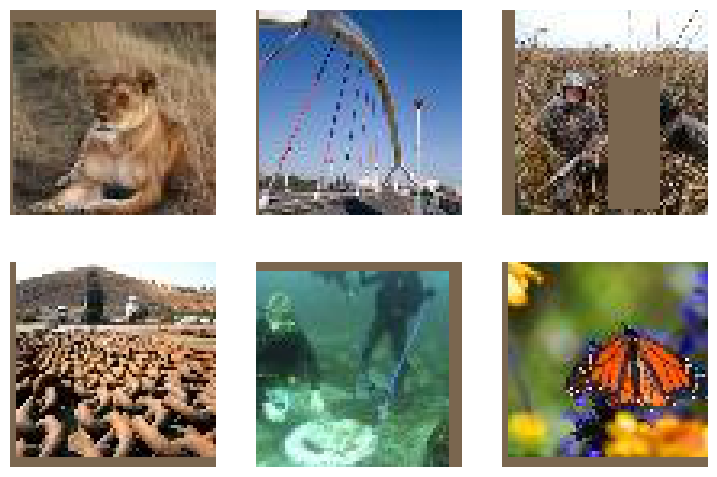

In [28]:
dls = get_imagenet_dls(bs=512, training_preprocessor=preprocess_and_augment)
viz(dls)

MulticlassAccuracy,loss,epoch,train
0.078,4.541,0,train
0.129,4.056,0,eval
0.166,3.847,1,train
0.154,4.086,1,eval
0.210,3.532,2,train
0.179,3.950,2,eval
0.247,3.317,3,train
0.174,3.973,3,eval
0.271,3.178,4,train
0.186,3.907,4,eval


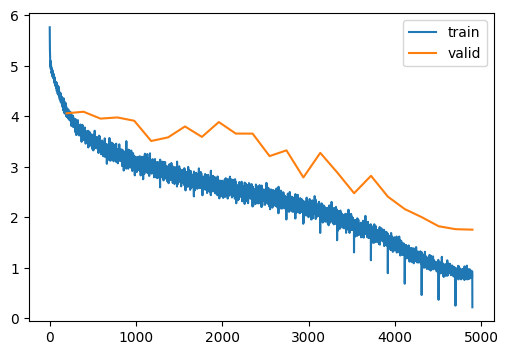

In [29]:
model = TinyImageResNet1.kaiming(
    n_outputs=200,
    nfs=[32, 64, 128, 256, 512, 1024],
)
train(model, dls, lr=0.1, n_epochs=25)

It does seem that augmentation is __critical__ for performance. Compare 58.6% accuracy (mine) vs 59.3% accuracy (Howard).	

## How much better can we do?

### Going deeper

To answer this, we can check [Papers With Code](https://paperswithcode.com/sota/image-classification-on-tiny-imagenet-1). The best approach documented there is the ResNext paper at 72% accurate. This benchmark has shifted since the original course publication date, but [here is the paper Jeremy refers to.](https://arxiv.org/pdf/2111.15454v3.pdf)

So, how much work is involved in going from 60% accurate to 70% accurate? "Real resnets" have multiple ResBlocks at the same feature map resolution.

In [30]:
n_blocks = (3, 2, 2, 1, 1)

This specification has five downsampling layers but nine ResBlocks

In [31]:
# |export
class StackableResidualConvBlock(nn.Sequential):
    def __init__(self, n_blocks, c_in, c_out, conv_cls=ResidualConvBlock):
        layers = []
        if n_blocks < 1:
            raise ValueError
        if n_blocks == 1:
            # Only one block, make sure to downsample
            downsample_height_width = conv_cls(c_in, c_out, stride=2)
            layers.append(downsample_height_width)
        else:
            for i in range(n_blocks - 1):
                # This differs slightly from Howard's implementation
                # because he disables the post-activation BatchNorm2d
                if i == 0:
                    layer = conv_cls(c_in, c_out, stride=1)
                else:
                    layer = conv_cls(c_out, c_out, stride=1)
                layers.append(layer)
            # In the last ResConvBlock, downsample the feature map
            # width and height by 2x, but do NOT change the number
            # of channels
            downsample_height_width = conv_cls(c_out, c_out, stride=2)
            layers.append(downsample_height_width)
        super().__init__(*layers)

This was a tricky module to implement. Make sure that the channel, height and width dimensions are apropriate for all values of n_blocks.

In [32]:
class TinyImageResNet2(TinyImageResNet1):
    def __init__(
        self,
        nfs,
        n_blocks,
        n_outputs=10,
        p_drop=0.1,
    ):
        self.n_blocks = n_blocks
        super().__init__(nfs, n_outputs, p_drop)

    def get_layers(self, nfs, n_outputs=10):
        layers = [Conv(3, nfs[0], stride=1, ks=5)]
        for c_in, c_out, n_blocks in zip(nfs, nfs[1:], self.n_blocks):
            layers.append(StackableResidualConvBlock(n_blocks, c_in, c_out))
        return layers

In [33]:
model = TinyImageResNet2.kaiming(
    n_outputs=200,
    nfs=[32, 64, 128, 256, 512, 1024],
    n_blocks=n_blocks,
)
summarize(model, [*model.layers, model.lin, model.norm], dls)

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (512, 3, 64, 64) | (512, 32, 64, 64) | 2,464 | 9.8
| StackableResidualConvBlock | (512, 32, 64, 64) | (512, 64, 32, 32) | 213,952 | 218.1
| StackableResidualConvBlock | (512, 64, 32, 32) | (512, 128, 16, 16) | 541,952 | 138.4
| StackableResidualConvBlock | (512, 128, 16, 16) | (512, 256, 8, 8) | 2,165,248 | 138.4
| StackableResidualConvBlock | (512, 256, 8, 8) | (512, 512, 4, 4) | 3,672,576 | 58.7
| StackableResidualConvBlock | (512, 512, 4, 4) | (512, 1024, 2, 2) | 14,685,184 | 58.7
| Linear | (512, 1024) | (512, 200) | 204,800 | 0.2
| BatchNorm1d | (512, 200) | (512, 200) | 400 | 0.0
| Total | | | 21,486,576 | 622.416528 |

MulticlassAccuracy,loss,epoch,train
0.068,4.621,0,train
0.101,4.285,0,eval
0.160,3.876,1,train
0.187,3.676,1,eval
0.226,3.429,2,train
0.221,3.561,2,eval
0.277,3.138,3,train
0.222,3.567,3,eval
0.312,2.952,4,train
0.283,3.124,4,eval


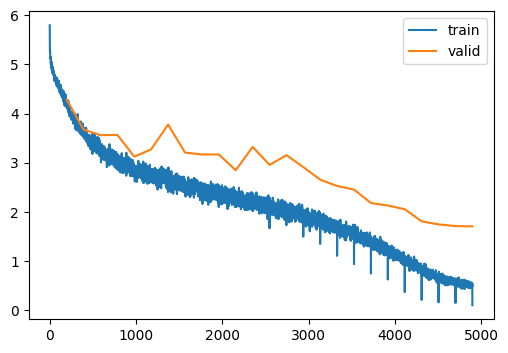

In [34]:
train(model, dls, lr=0.1, n_epochs=25)

### Yet more augmentation

In [35]:
T.TrivialAugmentWide?

Init signature:
T.TrivialAugmentWide(
    num_magnitude_bins: int = 31,
    interpolation: torchvision.transforms.functional.InterpolationMode = <InterpolationMode.NEAREST: 'nearest'>,
    fill: Optional[List[float]] = None,
) -> None
Docstring:     
Dataset-independent data-augmentation with TrivialAugment Wide, as described in
`"TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation" <https://arxiv.org/abs/2103.10158>`_.
If the image is torch Tensor, it should be of type torch.uint8, and it is expected
to have [..., 1 or 3, H, W] shape, where ... means an arbitrary number of leading dimensions.
If img is PIL Image, it is expected to be in mode "L" or "RGB".

Args:
    num_magnitude_bins (int): The number of different magnitude values.
    interpolation (InterpolationMode): Desired interpolation enum defined by
        :class:`torchvision.transforms.InterpolationMode`. Default is ``InterpolationMode.NEAREST``.
        If input is Tensor, only ``InterpolationMode.NEAREST``,

In [36]:
# |export
preprocess_and_trivial_augment = [
    to_rgb,
    T.Pad(4, fill=fill),
    T.RandomCrop(64, fill=fill),
    T.RandomHorizontalFlip(),
    T.TrivialAugmentWide(fill=fill),  # 👈
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    norm,
]

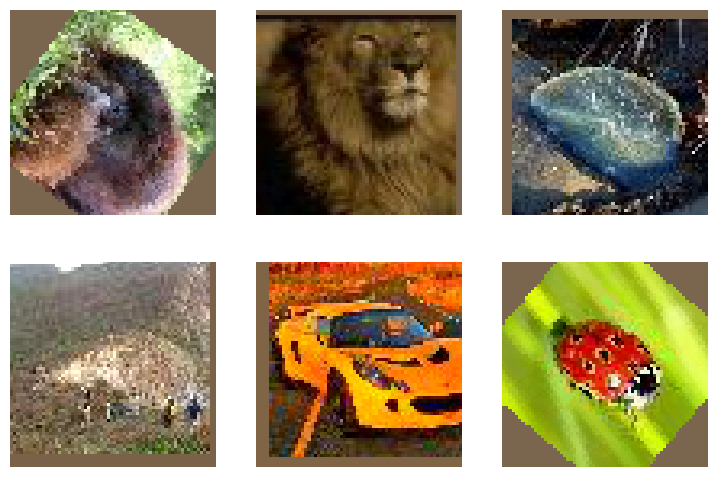

In [37]:
dls = get_imagenet_dls(bs=512, training_preprocessor=preprocess_and_trivial_augment)
viz(dls)

In [38]:
model = TinyImageResNet2.kaiming(
    n_outputs=200,
    nfs=[32, 64, 128, 256, 512, 1024],
    n_blocks=n_blocks,
)
summarize(model, [*model.layers, model.lin, model.norm], dls)

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (512, 3, 64, 64) | (512, 32, 64, 64) | 2,464 | 9.8
| StackableResidualConvBlock | (512, 32, 64, 64) | (512, 64, 32, 32) | 213,952 | 218.1
| StackableResidualConvBlock | (512, 64, 32, 32) | (512, 128, 16, 16) | 541,952 | 138.4
| StackableResidualConvBlock | (512, 128, 16, 16) | (512, 256, 8, 8) | 2,165,248 | 138.4
| StackableResidualConvBlock | (512, 256, 8, 8) | (512, 512, 4, 4) | 3,672,576 | 58.7
| StackableResidualConvBlock | (512, 512, 4, 4) | (512, 1024, 2, 2) | 14,685,184 | 58.7
| Linear | (512, 1024) | (512, 200) | 204,800 | 0.2
| BatchNorm1d | (512, 200) | (512, 200) | 400 | 0.0
| Total | | | 21,486,576 | 622.416528 |

MulticlassAccuracy,loss,epoch,train
0.040,4.902,0,train
0.075,4.431,0,eval
0.097,4.338,1,train
0.136,4.074,1,eval
0.147,3.954,2,train
0.180,3.691,2,eval
0.189,3.684,3,train
0.161,4.008,3,eval
0.223,3.488,4,train
0.193,3.875,4,eval


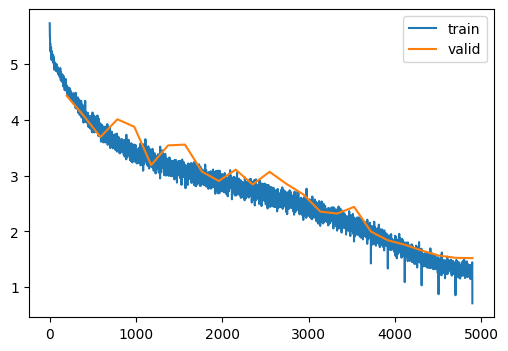

In [39]:
train(model, dls, lr=0.1, n_epochs=25)

In [ ]:
torch.save(model, "../models/tiny_imagenet_200_classifier.pt")

Continued in part 2...

In [23]:
#| hide
import nbdev

nbdev.nbdev_export()